In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.autograd import Variable
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18

In [338]:
iris = datasets.load_iris()

In [361]:
X = iris.data[:, [2,3]]
y = iris.target

In [340]:
X = X[y<2]
y = y[y<2]

In [341]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [342]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['kinds'] = pd.DataFrame(iris.target)

/Users/yugi/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/yugi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/yugi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


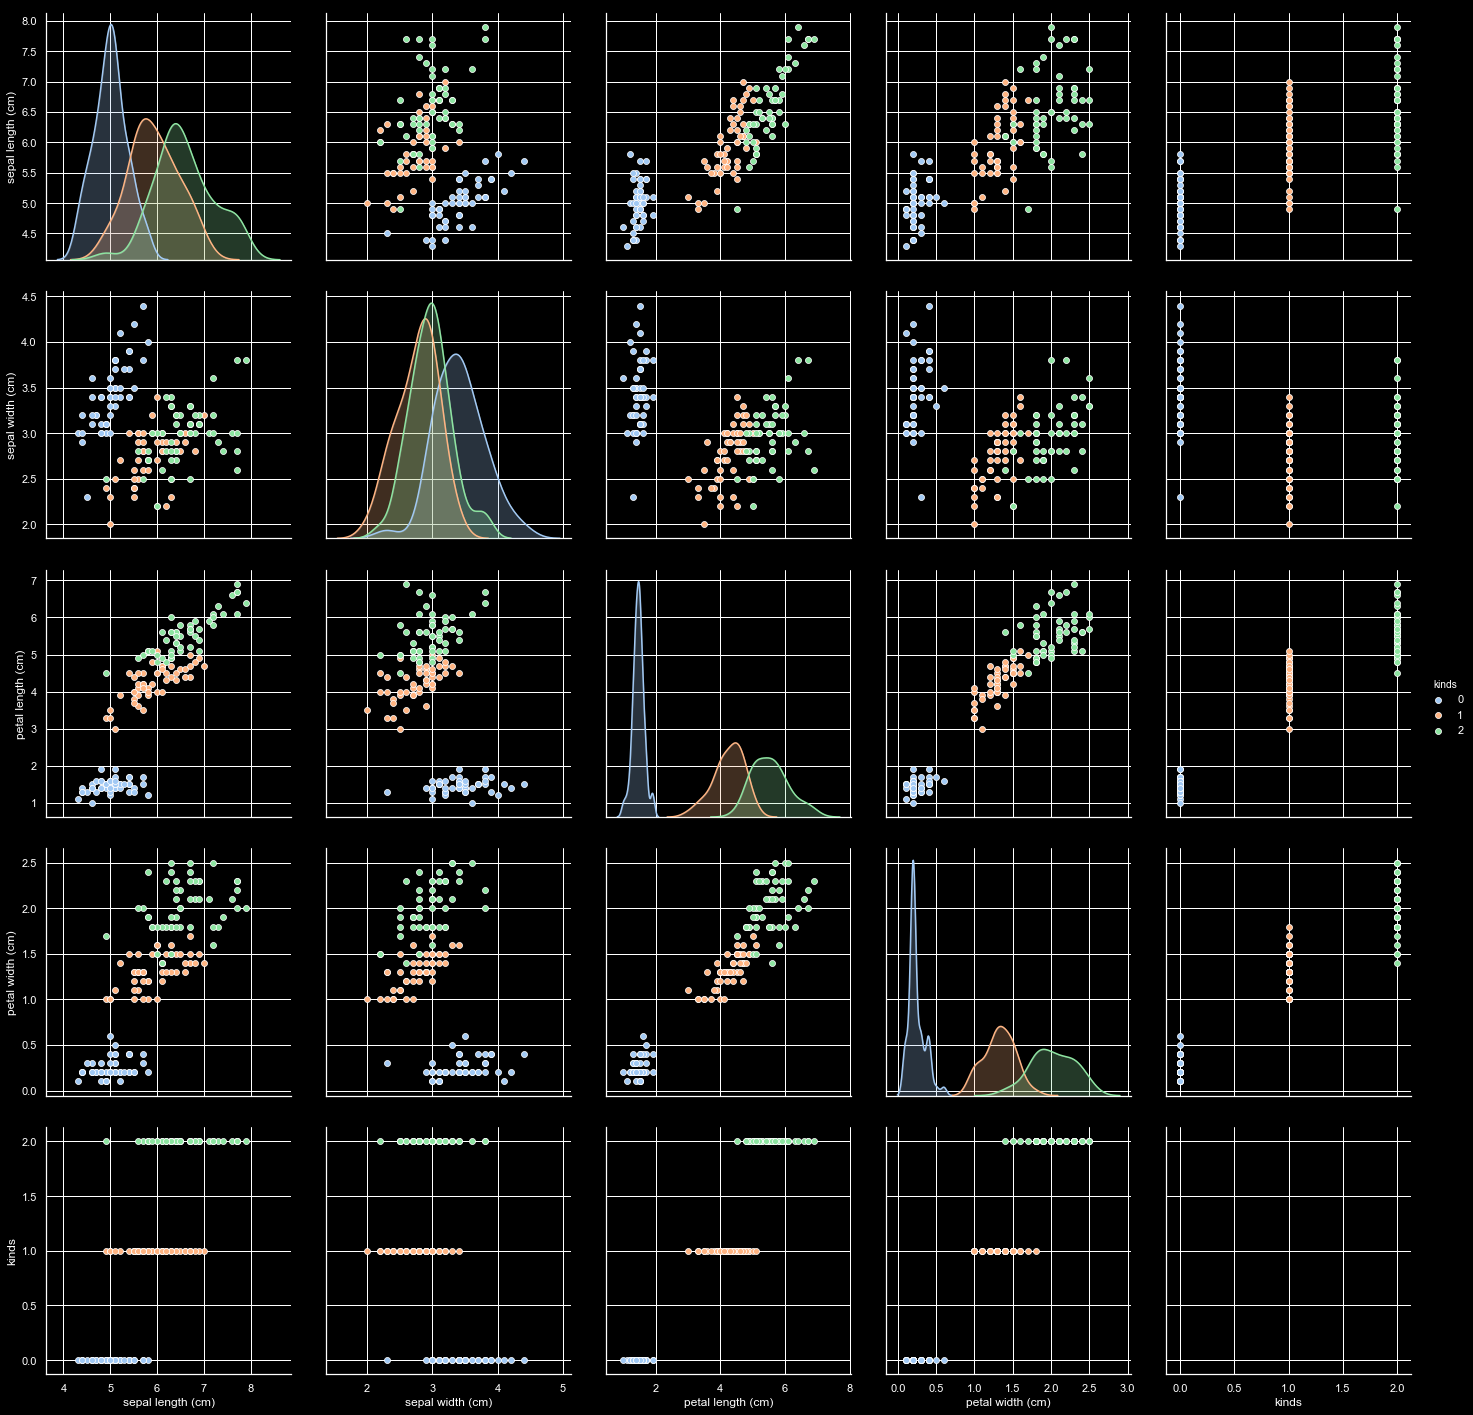

In [45]:
sns.pairplot(iris_df, hue='kinds',palette='pastel', size=4)

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)

In [47]:
lr.fit(X_train, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [50]:
print(X_train.shape)
print(X_test.shape)

(70, 2)
(30, 2)


<Figure size 432x288 with 0 Axes>

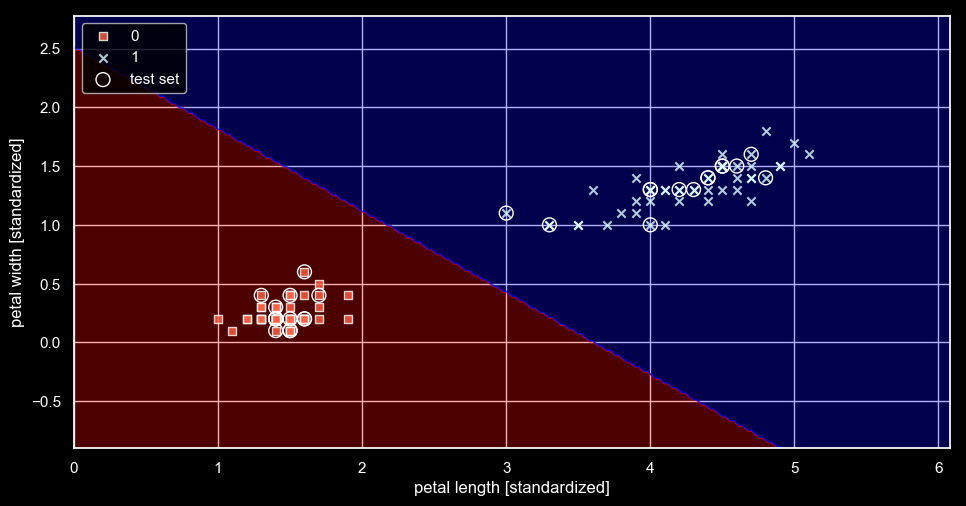

In [51]:
%run myGraph.py
plot_decision_regions(X=X_combined, y=y_combined, classifier=lr, test_idx=range(71,100))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

In [75]:
w = lr.coef_[0].reshape(2,1)

In [104]:
z = np.dot(X_test,w) + lr.intercept_

In [105]:
phi = 1 / (1 + np.exp(-z))

In [106]:
y_pred = [0 if s<= 0.5 else 1 for s in phi ]

In [107]:
correct = y_pred == y_test

In [108]:
correct

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

境界線の式  
$w_1 x_1 + w_2x_2 + intercept = 0$   
$x_2 = \frac{(-w_1 x_1 - intercept)}{w_2}$

In [121]:
x1 = np.linspace(0.5,5,100)
x2 = (-lr.coef_[0][0] * x1 - lr.intercept_) / lr.coef_[0][1]

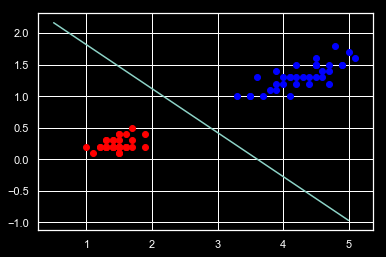

In [122]:
plt.plot(x1, x2)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], color='red')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='blue')

## PytorchでLogistic Regression

In [370]:
import torch
import torch.nn as nn

In [371]:
num_class = np.unique(y_train).shape[0]

In [372]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [373]:
net = nn.Linear(in_features=X_train.shape[1], out_features=1)
## 勾配降下法のオプティマイザーに上で定義したネットワークのパラメータを渡す
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
## MSE(mean squared error) lossクラス
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.CrossEntropyLoss()

In [374]:
def train(X_train, y_train):
#     inputs = torch.from_numpy(X_train).float()
#     targets = torch.from_numpy(y_train).float()
    inputs = Variable(torch.tensor(X_train).float())
    targets = Variable(torch.tensor(y_train).float())
    
    
    optimizer.zero_grad()
    outputs = net(inputs)

    loss = loss_fn(outputs, targets)
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [375]:
def valid(X_test, y_test):
#     inputs = torch.from_numpy(X_test).float()
#     targets = torch.from_numpy(y_test).float()
    inputs = Variable(torch.tensor(X_test).float())
    targets = Variable(torch.tensor(y_test).float())

    outputs = net(inputs)
    val_loss = loss_fn(outputs, targets)
    pred = torch.sigmoid(outputs)
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    
#     _, predicted = torch.max(outputs, 1)
#     correct = (predicted.float() == targets.float()).sum().item()
    correct = (pred == targets).sum().item()
    val_acc = float(correct) / targets.size(0)
    
    return val_loss.item(), val_acc

In [376]:
losses = []
val_losses = []
val_acces = []
epoch = 1000
for e in range(epoch):
    param = np.arange(X_train.shape[0])
    np.random.shuffle(param)
    X_train = X_train[param]
    y_train = y_train[param]
    
    loss = train(X_train, y_train)
    val_loss, val_acc = valid(X_test, y_test)
    
    if e % 100 == 0:
        print('epech {:d}, loss: {:.4f}, val_loss: {:.4f}, val_acc: {:4f}'.format(e, loss, val_loss, val_acc))
        
    losses.append(loss)
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    

epech 0, loss: 0.8448, val_loss: 0.8314, val_acc: 0.500000
epech 100, loss: 0.5714, val_loss: 0.5752, val_acc: 0.500000
epech 200, loss: 0.5315, val_loss: 0.5359, val_acc: 0.500000
epech 300, loss: 0.4966, val_loss: 0.5013, val_acc: 0.500000
epech 400, loss: 0.4650, val_loss: 0.4700, val_acc: 0.533333
epech 500, loss: 0.4363, val_loss: 0.4416, val_acc: 0.866667
epech 600, loss: 0.4104, val_loss: 0.4159, val_acc: 0.966667
epech 700, loss: 0.3868, val_loss: 0.3925, val_acc: 1.000000
epech 800, loss: 0.3654, val_loss: 0.3712, val_acc: 1.000000
epech 900, loss: 0.3459, val_loss: 0.3518, val_acc: 1.000000


In [284]:
val_loss, val_acc = valid(X_test, y_test)

In [310]:
val_acc

1.0

In [291]:
list(net.parameters())

[Parameter containing:
 tensor([[0.6392, 0.3726]], requires_grad=True), Parameter containing:
 tensor([-1.4614], requires_grad=True)]

In [299]:
ws = list(net.parameters())
w = ws[0].data.numpy()[0]
c = ws[1].data.numpy()[0]

In [308]:
x1 = np.linspace(1,3,100)
x2 = (-w[0] * x1 - c) / w[1]

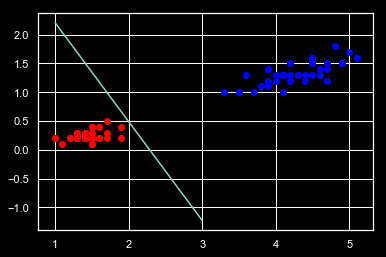

In [309]:
plt.plot(x1, x2)
plt.scatter(X_train[y_train[:,0]==0, 0], X_train[y_train[:,0]==0, 1], color='red')
plt.scatter(X_train[y_train[:,0]==1, 0], X_train[y_train[:,0]==1, 1], color='blue')